In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!unzip '/content/drive/My Drive/recommender_systems/ml-1m.zip'

Archive:  /content/drive/My Drive/recommender_systems/ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [3]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import correlation, cosine
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from keras.layers import Dense,Embedding,Input,Flatten,dot,BatchNormalization,LeakyReLU,Dropout,concatenate,multiply
from keras.losses import mean_squared_error
from keras.models import Model,load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import plot_model


Using TensorFlow backend.


In [0]:
data=pd.read_csv("/content/ml-1m/ratings.dat",sep="::",header=None,engine = 'python')

In [0]:
data.columns=["user_id","movie_id","rating","timestamp"]# Number of columns you can see in the dat file.

In [0]:
data.head(5)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [0]:
print('Number of unique users : %d ' % len(data['user_id'].unique()))
print('Number of unique movies : %d ' % len(data['movie_id'].unique()))

Number of unique users : 6040 
Number of unique movies : 3706 


In [0]:
print('Total number of ratings expected : %d ' % (len(data['user_id'].unique()) * len(data['movie_id'].unique())))  #22million
print('Total number of ratings in this dataset : %d ' % len(data))  #1million

Total number of ratings expected : 22384240 
Total number of ratings in this dataset : 1000209 


In [0]:
print('Minimum rating given by a user %.2f' % data['rating'].min())
print('Minimum rating given by a user %.2f' % data['rating'].max())

Minimum rating given by a user 1.00
Minimum rating given by a user 5.00


In [0]:
table = pd.pivot_table(data, index = 'user_id',columns = 'movie_id',values = 'rating')
table = table.fillna(0)
table.head(5)

movie_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
cosine_sim =1 - pairwise_distances(table, metric="cosine")
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df *= np.tri(*cosine_sim_df.values.shape, k=-1).T
cosine_sim_df = cosine_sim_df.stack()
cosine_sim_df = cosine_sim_df.reindex(cosine_sim_df.abs().sort_values(ascending=False).index).reset_index()
cosine_sim_df.columns = ["User_A", "User_B", "Cosine_Sim"]


In [0]:
cosine_sim =1 - pairwise_distances(table, metric="cosine")
cosine_sim_df = pd.DataFrame(cosine_sim)
cosine_sim_df *= np.tri(*cosine_sim_df.values.shape, k=-1).T
cosine_sim_df = cosine_sim_df.stack()
cosine_sim_df = cosine_sim_df.reindex(cosine_sim_df.sort_values(ascending=False).index).reset_index()
cosine_sim_df.columns = ["User_A", "User_B", "Cosine_Sim"]


In [0]:
which_user = 322
number_of_similar_users = 10
cosine_sim_df.iloc[sorted(np.concatenate((np.where(cosine_sim_df['User_A'] == which_user)[0][0:number_of_similar_users],np.where(cosine_sim_df['User_B'] == which_user)[0][0:number_of_similar_users])))][0:number_of_similar_users]

,User_A,User_B,Cosine_Sim
303511,322,397,0.373563
328669,322,3924,0.369198
342938,322,5216,0.366825
421032,322,5685,0.355072
459822,322,4131,0.349942
602081,322,3336,0.333816
610373,322,4021,0.332990
620434,322,1601,0.331971
632380,322,4489,0.330807
636102,322,3480,0.330441


#Neural Network Based *Collaborative Filtering*

In [0]:
dict_movie_id = dict()
j = 1
for i in sorted(data['movie_id'].unique()):
  dict_movie_id[i] = j
  j = j+1

In [0]:
data_new = data.copy()
data_new['movie_id'] = data['movie_id'].apply(lambda x: dict_movie_id[x])

In [0]:
mask = np.random.rand(len(data_new)) < 0.8
train = data_new[mask]
val = data_new[~mask]

In [0]:
len(train),len(val)

(800789, 199420)

In [0]:
data_new.head(5)

,user_id,movie_id,rating,timestamp
0,1,1105,5,978300760
1,1,640,3,978302109
2,1,854,3,978301968
3,1,3178,4,978300275
4,1,2163,5,978824291


In [0]:
train.head(5),val.head(5)

(   user_id  movie_id  rating  timestamp
 0        1      1105       5  978300760
 1        1       640       3  978302109
 2        1       854       3  978301968
 4        1      2163       5  978824291
 5        1      1108       3  978302268,
     user_id  movie_id  rating  timestamp
 3         1      3178       4  978300275
 6         1      1196       5  978302039
 11        1       878       4  978301752
 19        1      2593       4  978302039
 21        1       690       3  978300760)

In [0]:
del model

In [0]:
#USER
c1_in=Input(shape=(1,))
c1=Embedding(input_dim = len(data['user_id'].unique()),output_dim  = 96,embeddings_initializer='he_normal')(c1_in)
c1 =Flatten()(c1)
c1  = Dropout(0.4)(c1)


#MOVIE
c2_in=Input(shape=(1,))
c2=Embedding(input_dim = len(data['movie_id'].unique()),output_dim = 96,embeddings_initializer='he_normal')(c2_in)
c2=Flatten()(c2)
c2  = Dropout(0.4)(c2)


c1_c2 =dot([c1,c2],normalize = True,axes=1)   #cosine similarity
c3 = Dense(units = 128,kernel_initializer='he_normal')(c1_c2)
#c4 = BatchNormalization()(c3)
c5 = LeakyReLU(alpha = 0.2)(c3)
c6 = Dropout(0.45)(c5)

c7 = Dense(units = 1,activation = 'relu')(c6)
model =Model([c1_in, c2_in],c7)
es = EarlyStopping(monitor='val_loss', patience= 10, verbose=1,mode='min')

In [0]:
adam_opt = Adam(lr = 1e-4)
model.compile(optimizer=adam_opt,loss='mse',metrics = ['mae'])
history  = model.fit([train['user_id'],train['movie_id']],train['rating'], batch_size=1024,epochs =100, validation_data = ([val['user_id'],val['movie_id']],val['rating']),verbose = 1,callbacks= [es])

Train on 800789 samples, validate on 199420 samples
Epoch 1/100
800789/800789 [==============================] - 7s 9us/step - loss: 9.9000 - mean_absolute_error: 2.9087 - val_loss: 5.4780 - val_mean_absolute_error: 2.1095
Epoch 2/100
800789/800789 [==============================] - 7s 9us/step - loss: 3.0132 - mean_absolute_error: 1.4744 - val_loss: 1.5193 - val_mean_absolute_error: 1.0160
Epoch 3/100
800789/800789 [==============================] - 7s 8us/step - loss: 1.5135 - mean_absolute_error: 1.0086 - val_loss: 1.2924 - val_mean_absolute_error: 0.9489
Epoch 4/100
800789/800789 [==============================] - 6s 8us/step - loss: 1.4585 - mean_absolute_error: 0.9825 - val_loss: 1.2755 - val_mean_absolute_error: 0.9431
Epoch 5/100
800789/800789 [==============================] - 6s 8us/step - loss: 1.4364 - mean_absolute_error: 0.9752 - val_loss: 1.2652 - val_mean_absolute_error: 0.9401
Epoch 6/100
800789/800789 [==============================] - 6s 8us/step - loss: 1.4191 - mea

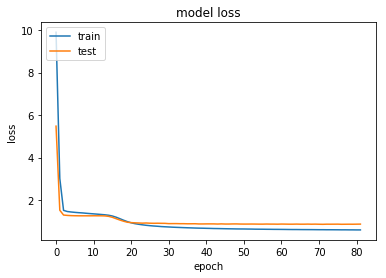

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
predictions =model.predict([val['user_id'],val['movie_id']])
test_performance = mean_absolute_error(val["rating"], predictions)
test_performance_r2 = r2_score(val['rating'],predictions)
print("Mean absolute error for model 1 with no bias units: %s " % test_performance)
print("r2 score for model 1 with no bias units: %s " % test_performance_r2)

Mean absolute error for model 1 with no bias units: 0.7236180240370759 
r2 score for model 1 with no bias units: 0.30492996083660484 


<h3>Mean absolute error for model 1 with no bias units: 0.7236180240370759 
<h3>r2 score for model 1 with no bias units: 0.30492996083660484 

#MODEL 2

In [0]:
#USER
c1_in=Input(shape=(1,))
c1=Embedding(input_dim = len(data['user_id'].unique()),output_dim  = 96,embeddings_initializer='he_normal')(c1_in)
c1_bias = Embedding(input_dim = len(data['user_id'].unique()),output_dim = 1,embeddings_initializer='he_normal')(c1_in)
#c1 =Flatten()(c1)
#c1  = Dropout(0.4)(c1)


#MOVIE
c2_in=Input(shape=(1,))
c2=Embedding(input_dim = len(data['movie_id'].unique()),output_dim = 96,embeddings_initializer='he_normal')(c2_in)
c2_bias = Embedding(input_dim = len(data['movie_id'].unique()),output_dim = 1,embeddings_initializer='he_normal')(c2_in)
#c2=Flatten()(c2)
#c2  = Dropout(0.4)(c2)


c1_c2 =multiply([c1,c2])
c4 = Dropout(0.4)(c1_c2)
c1_c2_bias = concatenate([c4, c1_bias, c2_bias])
c5 = Flatten()(c1_c2_bias)
c6 = Dense(units = 128,kernel_initializer='he_normal')(c5)
#c4 = BatchNormalization()(c3)
c7 = LeakyReLU(alpha = 0.2)(c6)
c8 = Dropout(0.45)(c7)

c9 = Dense(units = 1,activation = 'relu')(c8)
modelbias =Model([c1_in, c2_in],c9)
es = EarlyStopping(monitor='val_loss', patience= 20, verbose=1,mode='min')

In [0]:
adam_opt = Adam(lr = 1e-4)
modelbias.compile(optimizer=adam_opt,loss='mse',metrics = ["mae"])
history2  = modelbias.fit([train['user_id'],train['movie_id']],train['rating'], batch_size=1024,epochs =100, validation_data = ([val['user_id'],val['movie_id']],val['rating']),verbose = 1,callbacks = [es])

Train on 800789 samples, validate on 199420 samples
Epoch 1/100
800789/800789 [==============================] - 6s 8us/step - loss: 9.8978 - mean_absolute_error: 2.9084 - val_loss: 4.7900 - val_mean_absolute_error: 1.9609
Epoch 2/100
800789/800789 [==============================] - 6s 7us/step - loss: 2.2659 - mean_absolute_error: 1.2584 - val_loss: 1.1653 - val_mean_absolute_error: 0.9038
Epoch 3/100
800789/800789 [==============================] - 6s 8us/step - loss: 1.1881 - mean_absolute_error: 0.8867 - val_loss: 1.0139 - val_mean_absolute_error: 0.8191
Epoch 4/100
800789/800789 [==============================] - 6s 8us/step - loss: 1.0764 - mean_absolute_error: 0.8364 - val_loss: 0.9250 - val_mean_absolute_error: 0.7737
Epoch 5/100
800789/800789 [==============================] - 6s 7us/step - loss: 0.9949 - mean_absolute_error: 0.7998 - val_loss: 0.8698 - val_mean_absolute_error: 0.7457
Epoch 6/100
800789/800789 [==============================] - 6s 7us/step - loss: 0.9385 - mea

In [0]:
predictions =modelbias.predict([val['user_id'],val['movie_id']])
test_performance = mean_absolute_error(val["rating"], predictions)
test_performance_r2 = r2_score(val['rating'],predictions)
print("Mean absolute error for model 2 with bias units: %s " % test_performance)
print("r2 score for model 2 with bias units: %s " % test_performance_r2)

Mean absolute error for model 2 with bias units: 0.7011869081979457 
r2 score for model 2 with bias units: 0.3596083827767115 


<h3>Mean absolute error for model 2 with bias units: 0.7011869081979457 
<h3>r2 score for model 2 with bias units: 0.3596083827767115

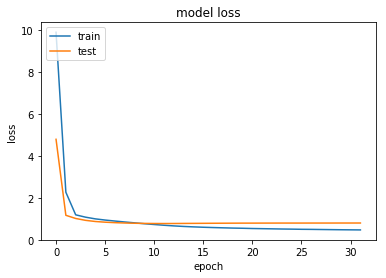

In [0]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.save('model1_nobias.h5')

In [0]:
modelbias.save('model2_withbias.h5')

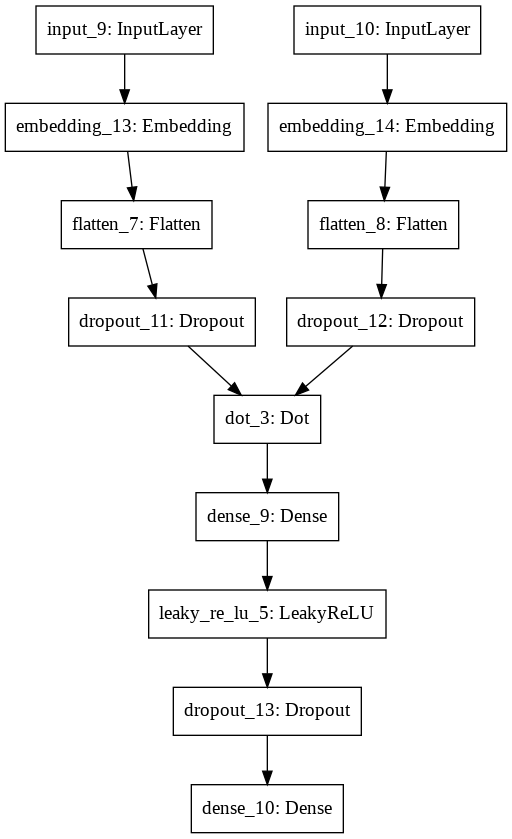

In [0]:
plot_model(model, to_file='model.png')

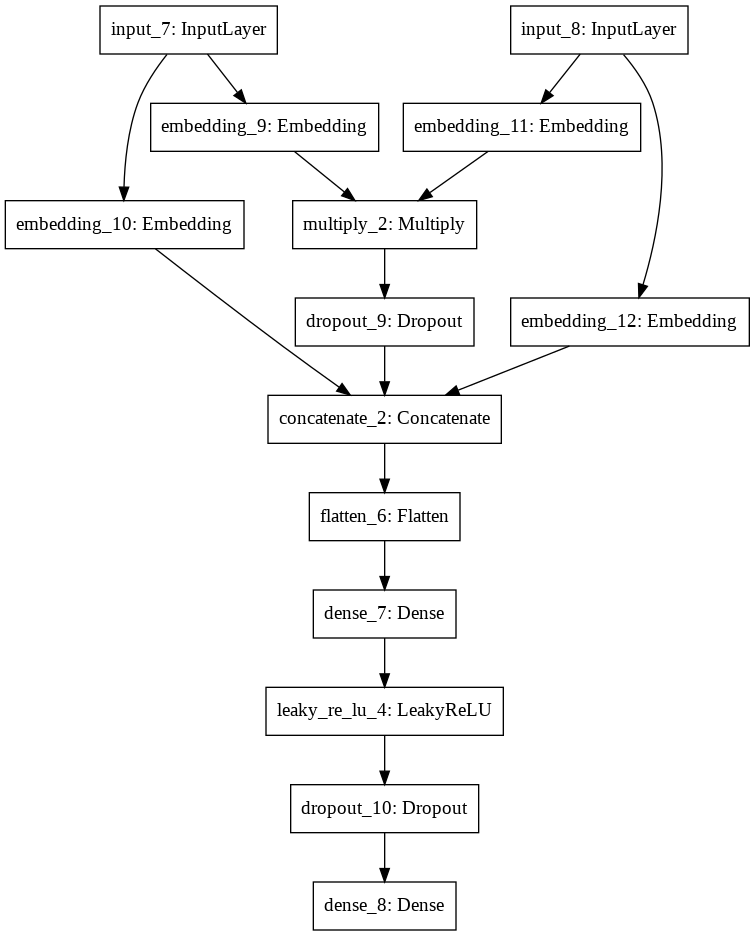

In [0]:
plot_model(modelbias, to_file='modelbias.png')

#Some Predictions

In [0]:
which_row = 465
pd.DataFrame(val.iloc[which_row,:]).drop(['timestamp']).T


,user_id,movie_id,rating
2422,19,1429,3


In [0]:
a1 = model.predict([pd.DataFrame([val.iloc[which_row,:][0]]),pd.DataFrame([val.iloc[which_row,:][1]])])
a2 = modelbias.predict([pd.DataFrame([val.iloc[which_row,:][0]]),pd.DataFrame([val.iloc[which_row,:][1]])])
print("Model 1 ratings %f" % a1)
print("Model 2 ratings %f" % a2)

Model 1 ratings 4.004258
Model 2 ratings 3.353845


In [0]:
which_row = 150
pd.DataFrame(val.iloc[which_row,:]).drop(['timestamp']).T


,user_id,movie_id,rating
814,10,3623,3


In [0]:
a1 = model.predict([pd.DataFrame([val.iloc[which_row,:][0]]),pd.DataFrame([val.iloc[which_row,:][1]])])
a2 = modelbias.predict([pd.DataFrame([val.iloc[which_row,:][0]]),pd.DataFrame([val.iloc[which_row,:][1]])])
print("Model 1 ratings %f" % a1)
print("Model 2 ratings %f" % a2)

Model 1 ratings 4.176280
Model 2 ratings 3.019052


In [0]:
which_row = 15000
pd.DataFrame(val.iloc[which_row,:]).drop(['timestamp']).T

,user_id,movie_id,rating
75512,513,2587,4


In [0]:
a1 = model.predict([pd.DataFrame([val.iloc[which_row,:][0]]),pd.DataFrame([val.iloc[which_row,:][1]])])
a2 = modelbias.predict([pd.DataFrame([val.iloc[which_row,:][0]]),pd.DataFrame([val.iloc[which_row,:][1]])])
print("Model 1 ratings %f" % a1)
print("Model 2 ratings %f" % a2)

Model 1 ratings 4.853716
Model 2 ratings 3.896684
